# project: medallions
- goal predict number of total rides

## Imports

In [1]:
# Section 1: Deep Learning (Keras)
# from keras.models import Sequential
# from keras.layers import Dense, LSTM
from math import sqrt

# Section 2: Time Series Forecasting (Prophet, ARIMA and SARIMAX)
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from prophet import Prophet

# Section 3: Utility Libraries
import itertools
from itertools import product
import numpy as np
import pandas as pd
import locale
from math import sqrt
from IPython.display import display, HTML

# Section 4: Data Transformation
from scipy.stats import boxcox
from sklearn.preprocessing import MinMaxScaler

# Section 5: Performance Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.diagnostic import normal_ad
from statsmodels.stats.diagnostic import het_breuschpagan
from sklearn.model_selection import ParameterGrid


# Section 6: Plotting
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import StrMethodFormatter
import seaborn as sns

# ORganize
from statsmodels.tsa.api import ExponentialSmoothing, SARIMAX
from sklearn.metrics import mean_squared_error
from prophet import Prophet
from pmdarima import auto_arima
import pandas as pd
from math import sqrt
import itertools
import pandas as pd
from sklearn.metrics import mean_squared_error
from prophet import Prophet
from math import sqrt
from sklearn.model_selection import ParameterGrid
from scipy.stats import skew, kurtosis, shapiro
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.stattools import acf, pacf


In [2]:
display(HTML("<style>div.output_scroll { height: 10em; }</style>"))
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


## Data Pre-Processing

In [3]:
data_reports_monthly = pd.read_csv('data_reports_monthly.csv')
data_reports_monthly.columns = data_reports_monthly.columns.str.strip()

# Make month/year index
data_reports_monthly['Month/Year'] = pd.to_datetime(data_reports_monthly['Month/Year'])
data_reports_monthly.set_index('Month/Year', inplace=True)

# Replace commas
data_reports_monthly = data_reports_monthly.replace({',': ''}, regex=True)

# Convert numeric columns to numeric
cols = data_reports_monthly.columns.drop(['License Class'])
data_reports_monthly[cols] = data_reports_monthly[cols].apply(pd.to_numeric, errors='coerce')

# Calculate Avg Trips per Vehicle
data_reports_monthly['Avg Trips per Vehicle'] = data_reports_monthly['Trips Per Day'] / data_reports_monthly['Vehicles Per Day']

# Create a new DataFrame with relevant columns
df = data_reports_monthly[['License Class', 'Trips Per Day']].copy()

# Calculate total NYC rides per Month/Year and assign the values to 'Total NYC Rides' column
df['Total NYC Rides'] = df.groupby('Month/Year')['Trips Per Day'].sum()

# Calculate the percentage of total rides
df['Percent of Total'] = df['Trips Per Day'] / df['Total NYC Rides']

# Get a list of unique license classes
license_classes = df['License Class'].unique()

# Sort Index

index = pd.to_datetime(df.index)
df = df.sort_index()
print(df.index.is_monotonic_increasing)


True


# Percent of Total Rides

In [6]:
# AutoArima AIC Single Vehicle

for license_class in license_classes:
    # Get the time series for this license class
    series = df[df['License Class'] == 'FHV - Black Car']['Percent of Total']
    
    # Split into train and test sets
    train, test = series[:-12], series[-12:]
    
    # Fit model with automatic order selection
    model = auto_arima(train, seasonal=True, trace=False)
    
    # Make predictions
    predictions = model.predict(n_periods=len(test))
    
    # Calculate RMSE
    rmse = sqrt(mean_squared_error(test, predictions))
    print(f'Test RMSE for {license_class}: {rmse:.8f}')


Test RMSE for Green: 0.00181016
Test RMSE for FHV - Livery: 0.00181016
Test RMSE for FHV - Black Car: 0.00181016
Test RMSE for FHV - High Volume: 0.00181016
Test RMSE for FHV - Lux Limo: 0.00181016
Test RMSE for Yellow: 0.00181016


Test RMSE for Green: 0.00032203
Test RMSE for FHV - Livery: 0.00550277
Test RMSE for FHV - Black Car: 0.00172625
Test RMSE for FHV - High Volume: 0.01198328
Test RMSE for FHV - Lux Limo: 0.00021128
Test RMSE for Yellow: 0.02092443


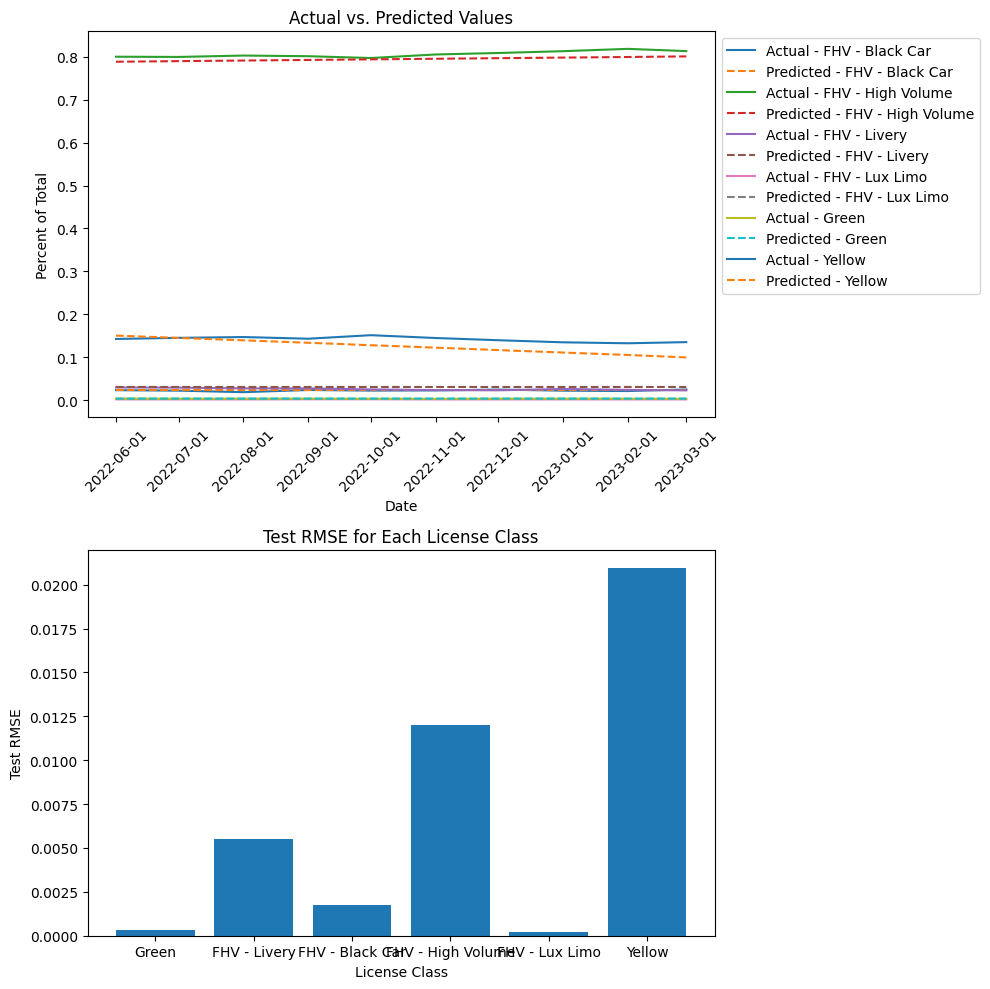

,License Class,Date,Actual,Predicted,Difference
2022-06-01,Green,2022-06-01,0.003311,0.003305,0.000006
2022-07-01,Green,2022-07-01,0.002940,0.003305,-0.000365
2022-08-01,Green,2022-08-01,0.003081,0.003295,-0.000214
2022-09-01,Green,2022-09-01,0.003109,0.003283,-0.000174
2022-10-01,Green,2022-10-01,0.002864,0.003280,-0.000416
2022-11-01,Green,2022-11-01,0.002775,0.003275,-0.000500
2022-12-01,Green,2022-12-01,0.002980,0.003269,-0.000289
2023-01-01,Green,2023-01-01,0.003001,0.003267,-0.000266
2023-02-01,Green,2023-02-01,0.002953,0.003264,-0.000311
2023-03-01,Green,2023-03-01,0.002870,0.003262,-0.000391


In [9]:
# Create an empty dataframe
results_df = pd.DataFrame(columns=['License Class', 'Date', 'Actual', 'Predicted', 'Difference'])

rmse_values = []

for license_class in license_classes:
    # Get the time series for this license class
    series = df[df['License Class'] == license_class]['Percent of Total']
    
    # Split into train and test sets
    train, test = series[:-10], series[-10:]
    
    # Fit model with automatic order selection
    model = auto_arima(train, seasonal=True, trace=False)
    
    # Make predictions
    predictions = model.predict(n_periods=len(test))
    
    # Calculate RMSE
    rmse = sqrt(mean_squared_error(test, predictions))
    rmse_values.append(rmse)
    
    # Create a temporary dataframe with the results for this license class
    temp_df = pd.DataFrame({
        'License Class': license_class,
        'Date': test.index,
        'Actual': test.values,
        'Predicted': predictions,
        'Difference': test.values - predictions
    })
    
    # Append the temporary dataframe to the main results dataframe
    results_df = pd.concat([results_df, temp_df])

    print(f'Test RMSE for {license_class}: {rmse:.8f}')


# Plot the actual and predicted values
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))
for license_class, data in results_df.groupby('License Class'):
    ax1.plot(data['Date'], data['Actual'], label=f'Actual - {license_class}')
    ax1.plot(data['Date'], data['Predicted'], linestyle='--', label=f'Predicted - {license_class}')
ax1.set_xlabel('Date')
ax1.set_ylabel('Percent of Total')
ax1.set_title('Actual vs. Predicted Values')
ax1.legend(loc='upper left', bbox_to_anchor=(1, 1))
ax1.set_xticks(data['Date'].unique())
ax1.set_xticklabels(data['Date'].dt.strftime('%Y-%m-%d').unique(), rotation=45)

# Plot the Test RMSE values
ax2.bar(license_classes, rmse_values)
ax2.set_xlabel('License Class')
ax2.set_ylabel('Test RMSE')
ax2.set_title('Test RMSE for Each License Class')

plt.tight_layout()
plt.show()

# Print the results dataframe
results_df
